In [1]:
#Import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import time

# sklearn
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

## Data

In [2]:
# Import data
data = pd.read_csv('../data/BankChurners.csv')

# Drop last two columns that are not needed
data = data.iloc[:, :-2]

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

## Basic Feature Engineering

In [4]:
# Create a new numeric column based on 'Attrition_Flag'
data['Attrited_Customer'] = np.where(data['Attrition_Flag'] == 'Existing Customer', 0, 1)
print(data['Attrited_Customer'].value_counts())
print(data['Attrited_Customer'].value_counts(normalize=True))

Attrited_Customer
0    8500
1    1627
Name: count, dtype: int64
Attrited_Customer
0    0.83934
1    0.16066
Name: proportion, dtype: float64


## Split the data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(data.drop(['CLIENTNUM','Attrition_Flag','Attrited_Customer'],axis=1), data['Attrited_Customer'], test_size=0.3, stratify=data['Attrited_Customer'], random_state=42)

In [27]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(7088, 19) (3039, 19) (7088,) (3039,)


## Feature Engineering

In [28]:
# Select categorial columns
categorical_columns = X_train.select_dtypes(include='object').columns

# Select numeric columns
numeric_columns = X_train.select_dtypes(include=['int64','float64']).columns

In [29]:
# Column Transformer
preprocessor = ColumnTransformer([
    ('num',StandardScaler(),numeric_columns),
    ('cat',OneHotEncoder(drop='if_binary',handle_unknown='ignore'),categorical_columns)
])

## Dataframe to store the results

In [30]:
results = pd.DataFrame(columns=['Model','Best_params','Accuracy', 'Precision','Recall','F1','ROC_AUC', 'Training_duration'])

## Baseline

In [31]:
# Create the pipeline for the baseline model
pipe_baseline = Pipeline([
    ('preprocessor',preprocessor),
    ('model',LogisticRegression())
])

In [32]:
# Fit the baseline model

start_time = time.time()

pipe_baseline.fit(X_train,y_train)

end_time = time.time()
training_duration = end_time - start_time

In [33]:
## Predict for the baseline
y_pred = pipe_baseline.predict(X_test)

# Predict probabilities for the test set
y_proba = pipe_baseline.predict_proba(X_test)[:, 1]


In [34]:
## Calculate the metrics

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

# Precision
precision = precision_score(y_test, y_pred)
print(f"Precision: {precision}")

# Recall
recall = recall_score(y_test, y_pred)
print(f"Recall: {recall}")

# F1 Score
f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC Score: {roc_auc}")


Accuracy: 0.8993089832181639
Precision: 0.7660818713450293
Recall: 0.5368852459016393
F1 Score: 0.6313253012048192
ROC-AUC Score: 0.9145103816568236


In [35]:
# Add metrics to the results DataFrame
new_row = {
    'Model': 'Baseline Model',
    'Best_params':'',
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1': f1,
    'ROC_AUC': roc_auc,
    'Training_duration': training_duration
}

new_row_df = pd.DataFrame([new_row])

results = pd.concat([results, new_row_df], ignore_index=True)


/var/folders/9f/_b6m_x357pv2yr00rnd6hh4h0000gq/T/ipykernel_73341/2218908546.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, new_row_df], ignore_index=True)


In [36]:
# Print the baseline results
results

,Model,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,,0.899309,0.766082,0.536885,0.631325,0.91451,0.052495


#### ROC-AUC Curve

In [37]:
## ROC AUC Curve
# y_proba contains the predicted probabilities for the positive class
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)


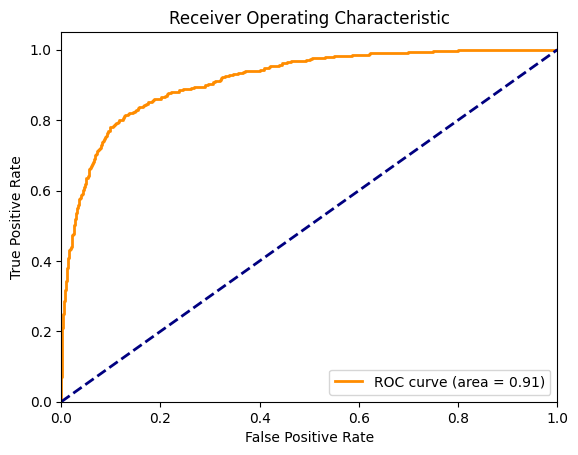

In [38]:
## ROC plot
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Confusion Matrix

In [39]:
cm = confusion_matrix(y_test, y_pred)

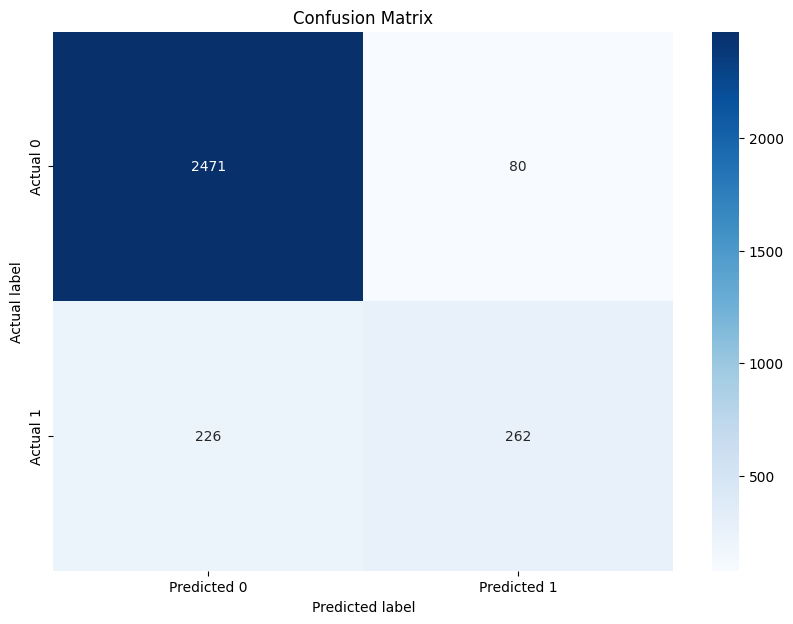

In [40]:
## Confusion Matrix plot
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.title('Confusion Matrix')
plt.show()


## Create the models with hyperparameters optimized

In [92]:
def model_creation_optimization(model_name, model, parameters, scoring_metric, results_df):
    '''
    Inputs: Model, param_grid, scoring
    1. Create the pipeline
    2. Create the GridSearchCV
    3. Fit the model
    4. Predict values and calculate probabilities
    5. Calculate metrics
    6. Add to results DataFrame
    7. Plot the ROC Curve
    8. Plot the cunfusion matrix
    '''

    # 1. Create the pipeline
    pipe_model = Pipeline([
        ('preprocessor',preprocessor),
        ('model',model)
    ])

    # 2. Create the GridSearchCV
    grid_search = GridSearchCV(pipe_model, param_grid=parameters[model_name], cv=5, scoring=scoring_metric,n_jobs=-1)

    # 3. Fit grid search on the training data and measure the training duration
    start_time = time.time()
    
    grid_search.fit(X_train, y_train)
    
    end_time = time.time()
    training_duration = end_time - start_time
    
    # Get the best parameters and model
    best_params = grid_search.best_params_
    best_model = grid_search.best_estimator_.named_steps['model']

    # Get the feature names
    feature_names = list(preprocessor.get_feature_names_out())

    # 4. Predict values and calculate probabilities
    y_pred = grid_search.best_estimator_.predict(X_test)
    y_proba = grid_search.best_estimator_.predict_proba(X_test)
    y_proba_1 = grid_search.best_estimator_.predict_proba(X_test)[:, 1]

    # 5. Calculate the metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba_1)

    # 6. Add to results DataFrame
    new_row = {
        'Model': model_name,
        'Best_params':best_params,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1': f1,
        'ROC_AUC': roc_auc,
        'Training_duration': training_duration
    }

    new_row_df = pd.DataFrame([new_row])

    # 7. Plot the ROC AUC Curve
    # y_proba_1 contains the predicted probabilities for the positive class
    fpr, tpr, thresholds = roc_curve(y_test, y_proba_1)
    roc_auc = auc(fpr, tpr)

    ## Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # 8. Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot the cunfision matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.title('Confusion Matrix')
    plt.show()

    # 9. Plot feature importance for DecisionTree and LogisticRegression
    if model_name == 'DecisionTree':
        importances = best_model.feature_importances_
        
        # Create the Dataframe with feature names and their importances
        feature_importance = pd.DataFrame(sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True),
                                          columns=['Feature', 'Importance'])

        
        # Sort the values in descending order
        feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
        
        # Concatenate the top 5 and bottom 5 features
        top_features = feature_importance.head(10)
        
        # Plotting
        plt.figure(figsize=(10, 8))
        ax = sns.barplot(data=top_features, x='Importance', y='Feature', dodge=False)
        plt.title('Top 10 Important Features for Decision Tree')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        
        # Loop through the bars and add the text annotations
        for p in ax.patches:
            width = p.get_width()
            ax.text(width,
                    p.get_y() + p.get_height() / 2,  
                    '{:.2f}'.format(width), 
                    va='center')
        
        plt.show()

        
    elif model_name == 'LogisticRegression':
        importances = best_model.coef_[0]

        # Create the Dataframe with feature names and their importances
        feature_importance = pd.DataFrame(sorted(zip(feature_names, importances), key=lambda x: x[1], reverse=True),
                                          columns=['Feature', 'Importance'])

        
        # Sort the values in descending order
        feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
        
        # Concatenate the top 5 and bottom 5 features
        top_bottom_features = pd.concat([feature_importance.head(5), feature_importance.tail(5)])
        
        # Plotting
        plt.figure(figsize=(10, 8))
        ax = sns.barplot(data=top_bottom_features, x='Importance', y='Feature', dodge=False)
        plt.title('Top and Bottom 5 Important Features for Logistic Regression')
        plt.xlabel('Feature Importance')
        plt.ylabel('Features')
        
        # Loop through the bars and add the text annotations
        for p in ax.patches:
            width = p.get_width()
            ax.text(width,
                    p.get_y() + p.get_height() / 2,  
                    '{:.2f}'.format(width), 
                    va='center')
        
        plt.show()


        
    
    return new_row_df



## Defining the models and Parameters

In [88]:
# Grid of values to search for Logistic Regression
param_grid = {
    'DecisionTree': {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 3, 5, 10, 20, 30, 40, 50], 'model__min_samples_split': [2, 5, 10],
                     'model__min_samples_leaf': [1, 2, 4], 'model__class_weight': [None, 'balanced']},  # Include 'balanced' to handle class imbalance    
    
    'SVM': {'model__C': [0.1, 1, 10], 'model__kernel': ['linear', 'rbf']},
    
    'LogisticRegression': [{'model__solver': ['liblinear'], 'model__penalty': ['l1', 'l2'], 'model__C': [0.01, 0.1, 1, 10, 100]},
        {'model__solver': ['lbfgs'], 'model__penalty': ['l2'], 'model__C': [0.01, 0.1, 1, 10, 100]}]
}

### Logistic Regression

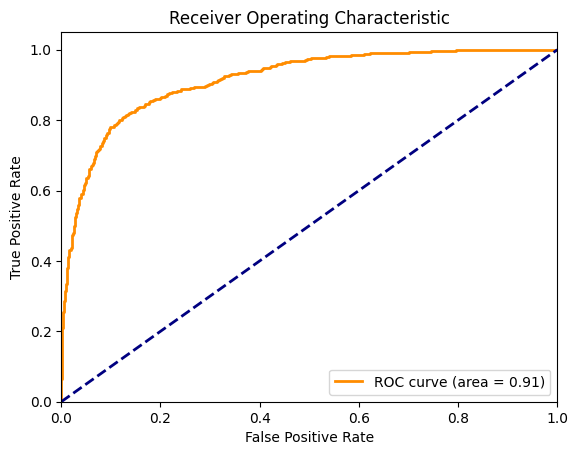

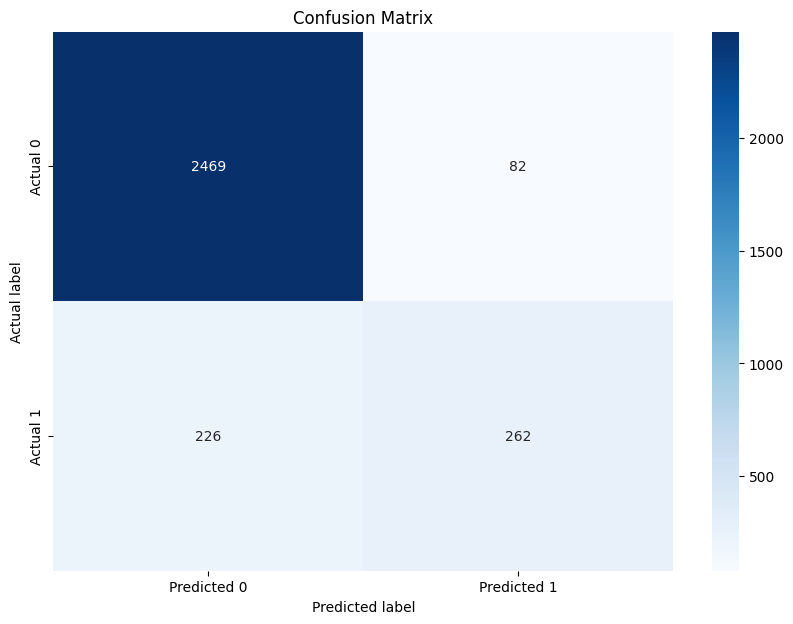

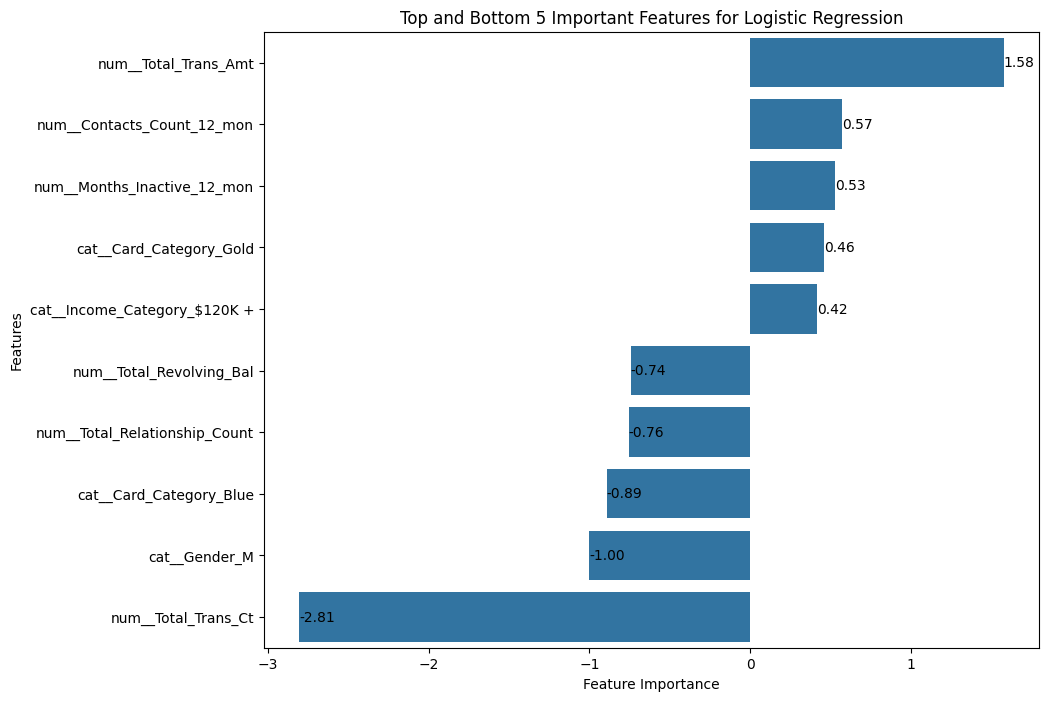

In [89]:
model_result = model_creation_optimization(model_name='LogisticRegression',model=LogisticRegression(max_iter=1000, random_state=42),parameters=param_grid,scoring_metric='f1',results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

In [90]:
results

,Model,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,,0.899309,0.766082,0.536885,0.631325,0.914510,0.052495
1,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,1.968249
2,SVM,"{'model__C': 10, 'model__kernel': 'rbf'}",0.934847,0.784314,0.819672,0.801603,0.964777,67.619918
3,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,4.359106
4,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,2.171643
5,DecisionTree,"{'model__class_weight': None, 'model__criterio...",0.935834,0.813704,0.778689,0.795812,0.911281,21.159776
6,DecisionTree,"{'model__class_weight': None, 'model__criterio...",0.935834,0.813704,0.778689,0.795812,0.911281,19.983447
7,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,2.110736
8,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,2.067335
9,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,2.123261


### SVM

['num__Customer_Age', 'num__Dependent_count', 'num__Months_on_book', 'num__Total_Relationship_Count', 'num__Months_Inactive_12_mon', 'num__Contacts_Count_12_mon', 'num__Credit_Limit', 'num__Total_Revolving_Bal', 'num__Avg_Open_To_Buy', 'num__Total_Amt_Chng_Q4_Q1', 'num__Total_Trans_Amt', 'num__Total_Trans_Ct', 'num__Total_Ct_Chng_Q4_Q1', 'num__Avg_Utilization_Ratio', 'cat__Gender_M', 'cat__Education_Level_College', 'cat__Education_Level_Doctorate', 'cat__Education_Level_Graduate', 'cat__Education_Level_High School', 'cat__Education_Level_Post-Graduate', 'cat__Education_Level_Uneducated', 'cat__Education_Level_Unknown', 'cat__Marital_Status_Divorced', 'cat__Marital_Status_Married', 'cat__Marital_Status_Single', 'cat__Marital_Status_Unknown', 'cat__Income_Category_$120K +', 'cat__Income_Category_$40K - $60K', 'cat__Income_Category_$60K - $80K', 'cat__Income_Category_$80K - $120K', 'cat__Income_Category_Less than $40K', 'cat__Income_Category_Unknown', 'cat__Card_Category_Blue', 'cat__Card

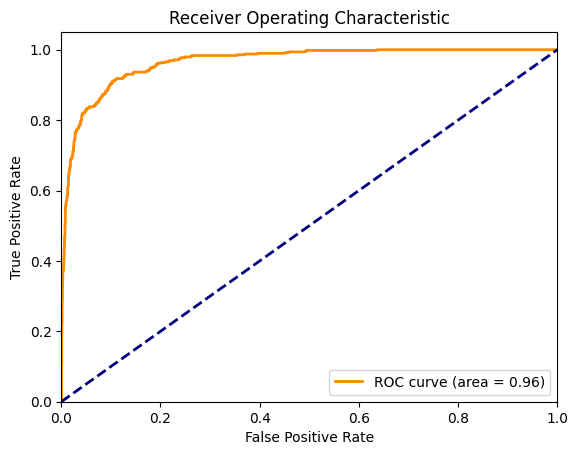

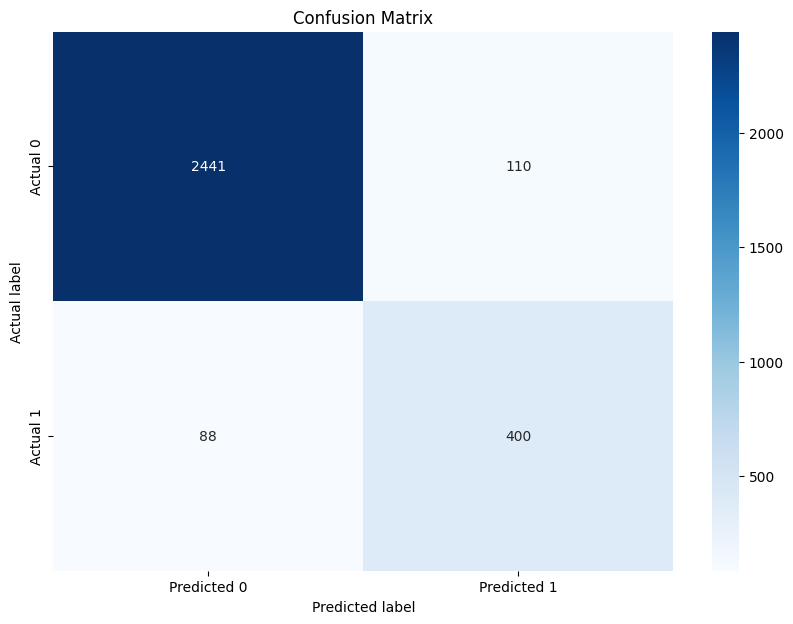

In [45]:
model_result = model_creation_optimization(model_name='SVM',model=SVC(probability=True, class_weight='balanced', random_state=42),
                                           parameters=param_grid,scoring_metric='f1',results_df=results)

results = pd.concat([results, model_result], ignore_index=True)

In [46]:
results

,Model,Best_params,Accuracy,Precision,Recall,F1,ROC_AUC,Training_duration
0,Baseline Model,,0.899309,0.766082,0.536885,0.631325,0.914510,0.052495
1,LogisticRegression,"{'model__C': 100, 'model__penalty': 'l2', 'mod...",0.898651,0.761628,0.536885,0.629808,0.914628,1.968249
2,SVM,"{'model__C': 10, 'model__kernel': 'rbf'}",0.934847,0.784314,0.819672,0.801603,0.964777,67.619918


## Decision Tree

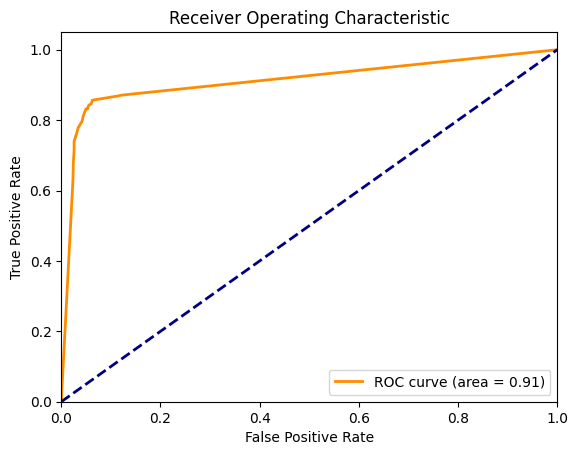

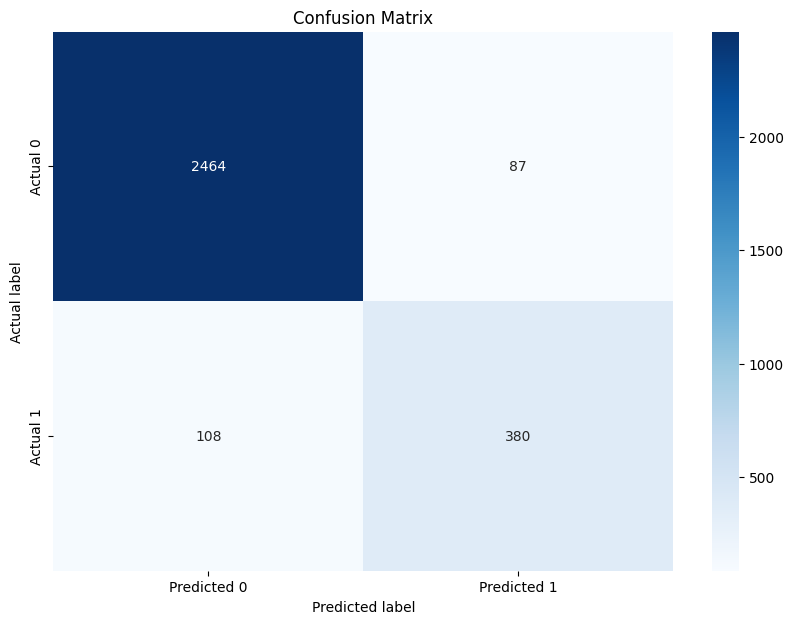

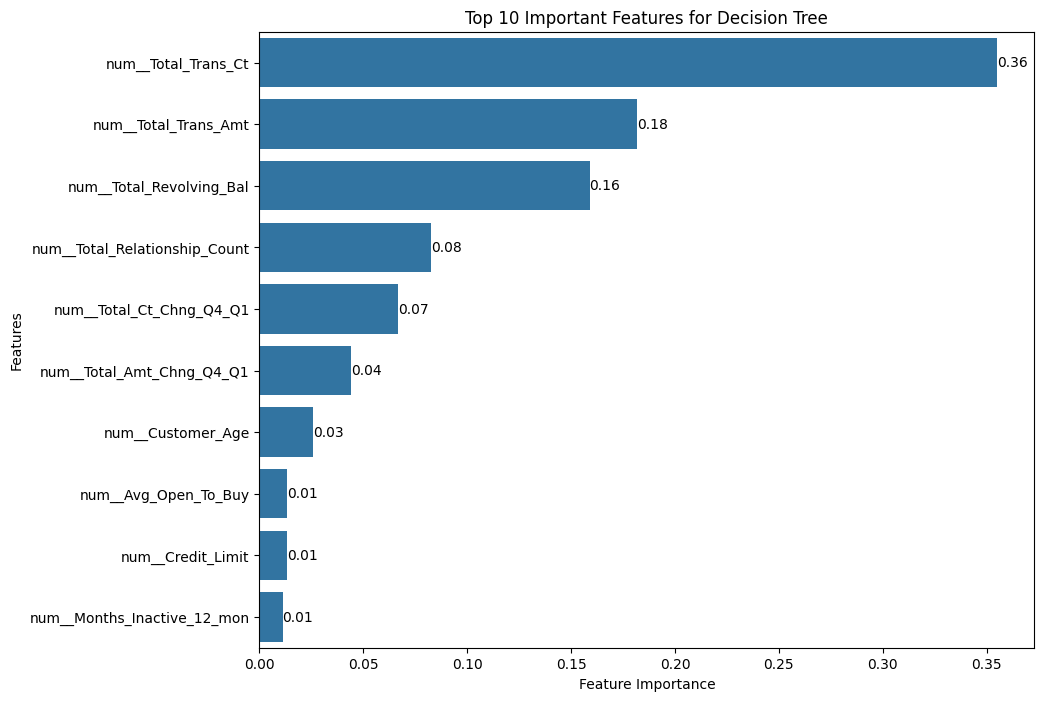

In [93]:
model_result = model_creation_optimization(model_name='DecisionTree',model=DecisionTreeClassifier(random_state=42),parameters=param_grid,scoring_metric='f1',results_df=results)
results = pd.concat([results, model_result], ignore_index=True)

In [ ]:
results

## Check Thresholds

In [ ]:
# Predicted value
y_pred = grid_search.best_estimator_.predict(X_test)

# Probability
y_proba = grid_search.best_estimator_.predict_proba(X_test)

In [ ]:
# Check probabilities

# Create a DataFrame from the probabilities
proba_df = pd.DataFrame(y_proba, columns=['Prob_Negative', 'Prob_Positive'])

# Reset index on y_test to align with the index from proba_df
y_test_reset = y_test.reset_index(drop=True)

# Concatenate the y_test Series and the probabilities DataFrame
results_df = pd.concat([y_test_reset, proba_df], axis=1)

# Assuming the default threshold is 0.5 to determine class predictions
# We use the second column "Prob_Positive" to compare with the threshold 0.5
results_df['y_pred_0_5'] = (results_df['Prob_Positive'] >= 0.5).astype(int)
results_df['y_pred_0_3'] = (results_df['Prob_Positive'] >= 0.4).astype(int)

In [ ]:
## True positive, False positive, True negative, False negative - 0.5
TN = len(results_df.query("Attrited_Customer==0 and y_pred_0_5==0"))
FP = len(results_df.query("Attrited_Customer==0 and y_pred_0_5==1"))
FN = len(results_df.query("Attrited_Customer==1 and y_pred_0_5==0"))
TP = len(results_df.query("Attrited_Customer==1 and y_pred_0_5==1"))

## Threshold 0.5
print(TN, FP)
print(FN, TP)

## True positive, False positive, True negative, False negative - 0.2
TN_0_3 = len(results_df.query("Attrited_Customer==0 and y_pred_0_3==0"))
FP_0_3 = len(results_df.query("Attrited_Customer==0 and y_pred_0_3==1"))
FN_0_3 = len(results_df.query("Attrited_Customer==1 and y_pred_0_3==0"))
TP_0_3 = len(results_df.query("Attrited_Customer==1 and y_pred_0_3==1"))

## Threshold 0.2
print(TN_0_2, FP_0_2)
print(FN_0_2, TP_0_2)

## True positive rate, False positive rate, True negative rate, False negative rate

In [ ]:
results_df.query("Attrited_Customer==0 and y_pred_0_3==1")